In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
#sns.set(style='ticks', context='poster')
#sns.set(style="whitegrid")
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.grid'] = True

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def rmse(X, y): return np.sqrt(mean_squared_error(X,y))

def print_score(m):
    print('RMSE train: ',rmse(y_train, m.predict(X_train)))
    print('RMSE test: ',rmse(y_test, m.predict(X_test)))
    print('R2 train: ',r2_score(y_train, m.predict(X_train)))
    print('R2 test: ',r2_score(y_test, m.predict(X_test)))

# Strategia di test

#### In questo notebook si vuole fittare un modello lineare ai dati, dal momento che le specifiche del progetto non parlano di un metodologia di testing specifica e dal momento che non mi è stato fornito un test set simulerò quello che potrebbe succedere nella realtà. 

#### Dal momento che abbiamo a che fare con variabili fisiche che variano nel tempo mi metto nella situazione reale in cui sarei testato su dati futuri non ancora misurati. Per simulare questa situazione la cosa ottimale da fare è quella di selezionare i dati più recenti del dataset a me fornitomi e utilizzarne una percentuale come datset di test. Per esempio posso assumere che l'istante di tempo attuale corrisponda al valore 7648 ovvero all'indice del valore corrispondente all'80% del dataset e che tutti i dati futuri non siano ancora stati misurati. Utilizzero quindi il primo 80% dei dati come dati di training e il restante 20% come dataset di test

# Strategia di validazione

#### Dal momento che i dati non hanno una dipendenza temporale e sono quindi dati iid  non occorre utilizzare una strategia di validazione necessaria se si ha a che fare con le serie temporali (Time Series K-fold Cross Validation tipica in ambito finanziario per effettuare il backtesting dei modelli). Utilizzerò' quindi la classica K-fold Cross Validation

# Metrica di valutazione

#### Dal momento che le specifiche del progetto non riportano una particolare metrica di valutazione per la valutazione delle predizioni dei modelli utilizzerò le metriche classiche di regressione come MSE, RMSE ed R^2, questo perchè ottimizzare le performance rispetto ad una di queste 3 metriche corrisponde ad ottimizzare le performances rispetto anche alle altre 2.

#### Non utilizzerò metriche come MAPE (Mean Absolute Percentage Error), sebbene metrica molto utilizzata sopratutto in ambito business, dal momento che per ottimizzare le performances rispetto a tale metrica dovrei riallenare i modelli pesando i dati inversamente rispetto al valore della target corrispondente in quanto tali metriche penalizzano maggiormente errori di predizione rispetto a valori bassi della target 

# Feature Engineering

#### Dal momento che il test non ha come obiettivo quello di ottenere le performance di predizioni migliori possibili, ma piuttosto ha come obiettivo quello di valutarci in  base ai nostri processi decisionali, valutazioni sull'importanza delle features e fase di modellizzazione, si è scelto di non effettuare feature engineering. 

# Training modello lineare

In [56]:
df = pd.read_csv('data/data02.csv', low_memory=False, index_col=0)

In [57]:
len(df)*0.8

7648.0

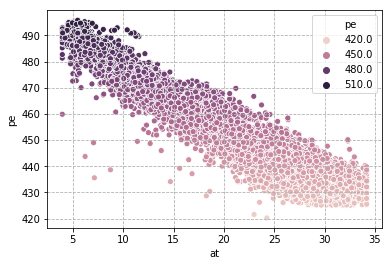

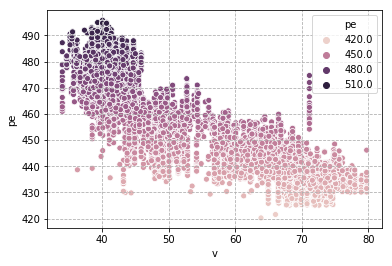

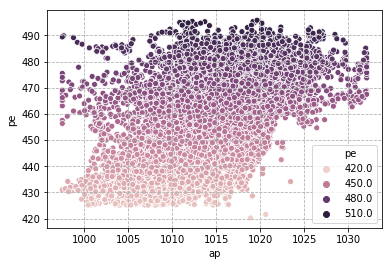

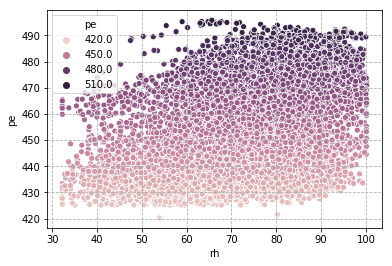

In [58]:
for var in df.drop('pe',axis=1).columns:
    ax = sns.scatterplot(x=var, y='pe',hue="pe", data=df)

    plt.show()

In [59]:
Y = df.pe.copy()
X = df.drop('pe',1).copy()

In [60]:
# seed = 2
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [61]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size].copy(), X[train_size:len(X)].copy()
y_train, y_test = Y[0:train_size].copy(), Y[train_size:len(X)].copy()

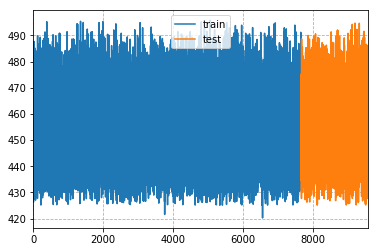

In [83]:
ax=y_train.plot()
y_test.plot(ax=ax)
ax.legend(['train','test'])

E' ben noto che l'alenamento dei modelli lineari avviene in maniera ottimale nel momento in cui le variabili di input sono opportunamente normalizzate, in questo caso utilizzerò una pipeline di sklearn che utilizza come primo passaggio lo Standard Scaler che per normalizzare non fa altro che sottrarre ad ogni variabile la propria media e dividerla per la deviazione standard.

Inoltre i modelli lineari assumono che le variabili siano linearmente correlate con la target e che abbiano una distribuzione Gaussiana, ciò sappiamo non essere vero per tutte le variabili, quello che possiamo fare per porre rimedio a ciò (e verrà effettuato in seguito) sarà quello di trasformare le variabili v e rh in modo opportuno.

In [62]:
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

params = {'polynomialfeatures__degree': [1],
         'ridge__alpha': [0.0, 0.1, 1, 10]}

gsearch2b = GridSearchCV(pipeline, param_grid=params, cv=5, return_train_score=True)
gsearch2b.fit(X_train, y_train)
print("gsearch2b.best_params_",gsearch2b.best_params_)
print("R2 di train medio con parametro migliore",
      [gsearch2b.cv_results_['mean_train_score'][i] for i,x in enumerate(gsearch2b.cv_results_['params']) if x==gsearch2b.best_params_][0])
print("R2 di validazione medio con parametro migliore",gsearch2b.best_score_)

gsearch2b.best_params_ {'polynomialfeatures__degree': 1, 'ridge__alpha': 0.0}
R2 di train medio con parametro migliore 0.9275960216574161
R2 di validazione medio con parametro migliore 0.9273342947887855


In [63]:
print_score(gsearch2b.best_estimator_)

RMSE train:  4.573934855288108
RMSE test:  4.462857146692867
R2 train:  0.9275857414855269
R2 test:  0.9338174048660854


Proviamo a trasformale la variabile v e osservre se le performance migliorano

In [64]:
df.v=1.0/df.v

In [65]:
Y = df.pe.copy()
X = df.drop('pe',1).copy()

train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]

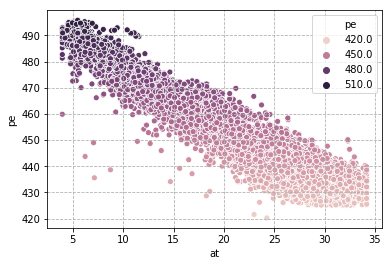

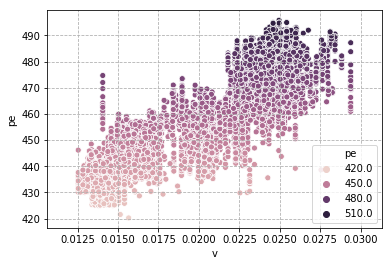

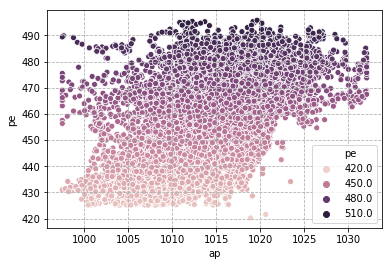

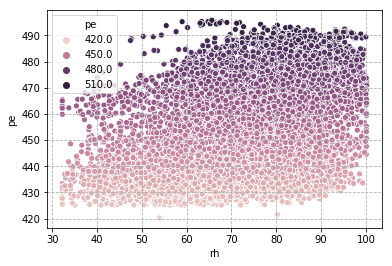

In [66]:
for var in df.drop('pe',axis=1).columns:
    ax = sns.scatterplot(x=var, y='pe',hue="pe", data=df)

    plt.show()

In [67]:
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

params = {'polynomialfeatures__degree': [1],
         'ridge__alpha': [0.0, 0.1, 1, 10]}

gsearch2b = GridSearchCV(pipeline, param_grid=params, cv=5, return_train_score=True)
gsearch2b.fit(X_train, y_train)
print("gsearch2b.best_params_",gsearch2b.best_params_)
print("R2 di train medio con parametro migliore",
      [gsearch2b.cv_results_['mean_train_score'][i] for i,x in enumerate(gsearch2b.cv_results_['params']) if x==gsearch2b.best_params_][0])
print("R2 di validazione medio con parametro migliore",gsearch2b.best_score_)

gsearch2b.best_params_ {'polynomialfeatures__degree': 1, 'ridge__alpha': 0.0}
R2 di train medio con parametro migliore 0.9290746326108461
R2 di validazione medio con parametro migliore 0.928815104909331


Si osserva un leggero aumento delle performance

In [68]:
print_score(gsearch2b.best_estimator_)

RMSE train:  4.526990469723448
RMSE test:  4.424666944361955
R2 train:  0.9290645547876497
R2 test:  0.9349452528607369


Dal momento che questo modello è il migliore lo rialleno sull'intero dataset e lo salvo

In [69]:
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(1), Ridge(alpha=0))
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [70]:
print_score(pipeline)

RMSE train:  4.526990469723448
RMSE test:  4.424666944361955
R2 train:  0.9290645547876497
R2 test:  0.9349452528607369


In [71]:
from joblib import dump
import os

directory='models'

if not os.path.exists(directory):
    os.makedirs(directory)

dump(pipeline, 'models/Ridge.joblib') 

['models/Ridge.joblib']

Proviamo a trasformare la variabile rh, che presenta skew negativa, per renderla più Gaussiana

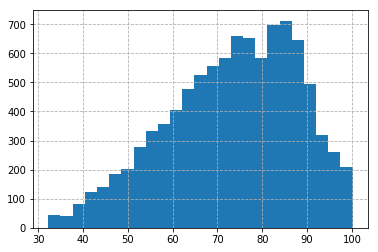

In [72]:
df.rh.hist(bins=25)

In [73]:
df.rh=df.rh**2

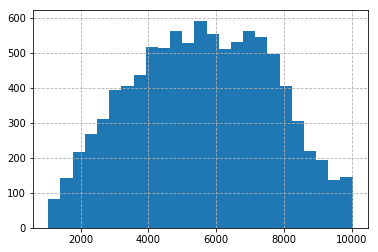

In [74]:
df.rh.hist(bins=25)

In [75]:
Y = df.pe.copy()
X = df.drop('pe',1).copy()

train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]

In [76]:
pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

params = {'polynomialfeatures__degree': [1],
         'ridge__alpha': [0.0, 0.1, 1, 10]}

gsearch2b = GridSearchCV(pipeline, param_grid=params, cv=5, return_train_score=True)
gsearch2b.fit(X_train, y_train)
print("gsearch2b.best_params_",gsearch2b.best_params_)
print("R2 di train medio con parametro migliore",
      [gsearch2b.cv_results_['mean_train_score'][i] for i,x in enumerate(gsearch2b.cv_results_['params']) if x==gsearch2b.best_params_][0])
print("R2 di validazione medio con parametro migliore",gsearch2b.best_score_)

gsearch2b.best_params_ {'polynomialfeatures__degree': 1, 'ridge__alpha': 0.0}
R2 di train medio con parametro migliore 0.9286056139327815
R2 di validazione medio con parametro migliore 0.9283409036003935


In [78]:
print_score(gsearch2b.best_estimator_)

RMSE train:  4.541954966471325
RMSE test:  4.4432566334043635
R2 train:  0.9285948088385845
R2 test:  0.934397465650061
